In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-11 20:21:41.930934: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-11 20:21:42.753597: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-11 20:21:42.797396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 20:21:42.797443: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 20:21:42.801785: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 20:21:42.801858: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-11 20:21:42.803787: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

eco_gen_GASF_13m_100S5X11A38085_R12_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']
{0: 4.72665218740304, 1: 0.17788312772578393, 2: 0.5904536733784229, 3: 2.508893280632411, 4: 2.2035148622260796, 5: 10.612330198537094, 6: 0.8248416265092858, 7: 3.213246150601139, 8: 1.347843397478434, 9: 5.1869254341164455, 10: 14.655122655122655}
 
Tests 
HEKA test: 146 train: 586
fridge/freezer test: 3893 train: 15571
HTPC test: 1173 train: 4691
audio system test: 276 train: 1104
broadband router test: 314 train: 1257
coffee maker test: 65 train: 261
computer test: 839 train: 3358
lamp test: 216 train: 862
laptop computer test: 514 train: 2055
microwave test: 134 train: 534
washing machine test: 47 train: 189


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/BI_LSTM/eco/TL/eco_12_refit, iawe, redd, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data eco training on model refit seed 12
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']
{0: 4.72665218740304, 1: 0.17788312772578393, 2: 0.5904536733784229, 3: 2.508893280632411, 4: 2.2035148622260796, 5: 10.612330198537094, 6: 0.8248416265092858, 7: 3.213246150601139, 8: 1.347843397478434, 9: 5.1869254341164455, 10: 14.655122655122655}
 
Tests 
HEKA test: 146 train: 586
fridge/freezer test: 3893 train: 15571
HTPC test: 1173 train: 4691
audio system test: 276 train: 1104
broadband router test: 314 train: 1257
coffee maker test: 65 train: 261
computer test: 839 train: 3358
lamp test: 216 train: 862
laptop computer test: 514 train: 2055
microwave test: 134 train: 534
washing machine test: 47 train: 189
loading model
compling TL model..


2022-02-11 20:21:46.791063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 20:21:46.844284: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-11 20:21:46.844350: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 20:21:47.231271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-11 20:21:47.231306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-11 20:21:47.231313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-11 20:21:47.231877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-11 20:21:55.002549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-11 20:21:55.020616: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-11 20:21:58.456580: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-11 20:21:59.228213: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-11 20:22:00.091275: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 20:22:00.511780: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


953/953 - 24s - loss: 0.8231 - accuracy: 0.6501
Epoch 2/50
953/953 - 23s - loss: 0.6007 - accuracy: 0.7247
Epoch 3/50
953/953 - 23s - loss: 0.5627 - accuracy: 0.7423
Epoch 4/50
953/953 - 22s - loss: 0.5429 - accuracy: 0.7477
Epoch 5/50
953/953 - 22s - loss: 0.5227 - accuracy: 0.7539
Epoch 6/50
953/953 - 22s - loss: 0.5121 - accuracy: 0.7632
Epoch 7/50
953/953 - 23s - loss: 0.4990 - accuracy: 0.7690
Epoch 8/50
953/953 - 22s - loss: 0.4860 - accuracy: 0.7732
Epoch 9/50
953/953 - 23s - loss: 0.4915 - accuracy: 0.7739
Epoch 10/50
953/953 - 23s - loss: 0.4742 - accuracy: 0.7785
Epoch 11/50
953/953 - 22s - loss: 0.4802 - accuracy: 0.7760
Epoch 12/50
953/953 - 22s - loss: 0.4777 - accuracy: 0.7799
Epoch 13/50
953/953 - 23s - loss: 0.4640 - accuracy: 0.7827
Epoch 14/50
953/953 - 23s - loss: 0.4703 - accuracy: 0.7829
Epoch 15/50
953/953 - 23s - loss: 0.4634 - accuracy: 0.7890
Epoch 16/50
953/953 - 22s - loss: 0.4591 - accuracy: 0.7837
Epoch 17/50
953/953 - 22s - loss: 0.4584 - accuracy: 0.7835


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
953/953 - 22s - loss: 1.4137 - accuracy: 0.4601
Epoch 2/50
953/953 - 23s - loss: 1.1055 - accuracy: 0.5250
Epoch 3/50
953/953 - 23s - loss: 1.0293 - accuracy: 0.5498
Epoch 4/50
953/953 - 23s - loss: 0.9911 - accuracy: 0.5622
Epoch 5/50
953/953 - 23s - loss: 0.9702 - accuracy: 0.5681
Epoch 6/50
953/953 - 23s - loss: 0.9576 - accuracy: 0.5761
Epoch 7/50
953/953 - 23s - loss: 0.9112 - accuracy: 0.5895
Epoch 8/50
953/953 - 23s - loss: 0.9218 - accuracy: 0.5896
Epoch 9/50
953/953 - 22s - loss: 0.9116 - accuracy: 0.5891
Epoch 10/50
953/953 - 22s - loss: 0.8866 - accuracy: 0.6005
Epoch 11/50
953/953 - 24s - loss: 0.8760 - accuracy: 0.6006
Epoch 12/50
953/953 - 23s - loss: 0.8789 - accuracy: 0.6101
Epoch 13/50
953/953 - 22s - loss: 0.8508 - accuracy: 0.6158
Epoch 14/50
953/953 - 23s - loss: 0.8721 - accuracy: 0.6097
Epoch 15/50
953/953 - 21s - loss: 0.8607 - accuracy: 0.6188
Epoch 16/50
953/953 - 23s - loss: 0.8612 - accuracy: 0.6151
Epoch 17/50
953/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
953/953 - 22s - loss: 1.1430 - accuracy: 0.5956
Epoch 2/50
953/953 - 23s - loss: 0.8753 - accuracy: 0.6434
Epoch 3/50
953/953 - 23s - loss: 0.7949 - accuracy: 0.6650
Epoch 4/50
953/953 - 23s - loss: 0.7575 - accuracy: 0.6745
Epoch 5/50
953/953 - 23s - loss: 0.7540 - accuracy: 0.6817
Epoch 6/50
953/953 - 23s - loss: 0.6995 - accuracy: 0.6966
Epoch 7/50
953/953 - 23s - loss: 0.6955 - accuracy: 0.7066
Epoch 8/50
953/953 - 24s - loss: 0.6757 - accuracy: 0.7123
Epoch 9/50
953/953 - 23s - loss: 0.6753 - accuracy: 0.7112
Epoch 10/50
953/953 - 23s - loss: 0.6528 - accuracy: 0.7175
Epoch 11/50
953/953 - 22s - loss: 0.6368 - accuracy: 0.7183
Epoch 12/50
953/953 - 23s - loss: 0.6456 - accuracy: 0.7199
Epoch 13/50
953/953 - 22s - loss: 0.6359 - accuracy: 0.7243
Epoch 14/50
953/953 - 22s - loss: 0.6421 - accuracy: 0.7246
Epoch 15/50
953/953 - 22s - loss: 0.6204 - accuracy: 0.7302
Epoch 16/50
953/953 - 23s - loss: 0.6134 - accuracy: 0.7303
Epoch 17/50
953/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
953/953 - 22s - loss: 1.0818 - accuracy: 0.5163
Epoch 2/50
953/953 - 23s - loss: 0.8044 - accuracy: 0.6166
Epoch 3/50
953/953 - 22s - loss: 0.7571 - accuracy: 0.6394
Epoch 4/50
953/953 - 23s - loss: 0.7272 - accuracy: 0.6595
Epoch 5/50
953/953 - 23s - loss: 0.6891 - accuracy: 0.6690
Epoch 6/50
953/953 - 23s - loss: 0.6973 - accuracy: 0.6722
Epoch 7/50
953/953 - 23s - loss: 0.6625 - accuracy: 0.6791
Epoch 8/50
953/953 - 23s - loss: 0.6532 - accuracy: 0.6887
Epoch 9/50
953/953 - 23s - loss: 0.6496 - accuracy: 0.6853
Epoch 10/50
953/953 - 23s - loss: 0.6353 - accuracy: 0.6960
Epoch 11/50
953/953 - 23s - loss: 0.6307 - accuracy: 0.6997
Epoch 12/50
953/953 - 22s - loss: 0.6329 - accuracy: 0.7028
Epoch 13/50
953/953 - 23s - loss: 0.6227 - accuracy: 0.7029
Epoch 14/50
953/953 - 22s - loss: 0.6162 - accuracy: 0.7062
Epoch 15/50
953/953 - 23s - loss: 0.6115 - accuracy: 0.7067
Epoch 16/50
953/953 - 23s - loss: 0.6136 - accuracy: 0.7074
Epoch 17/50
953/

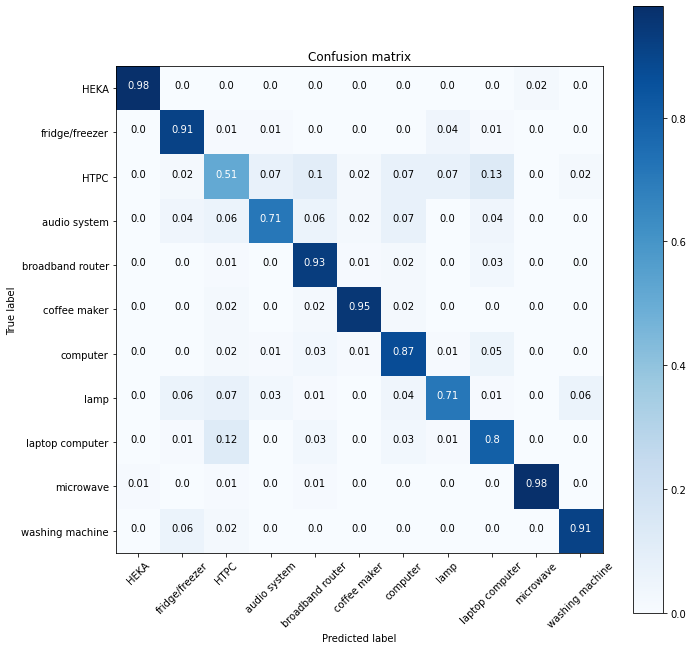

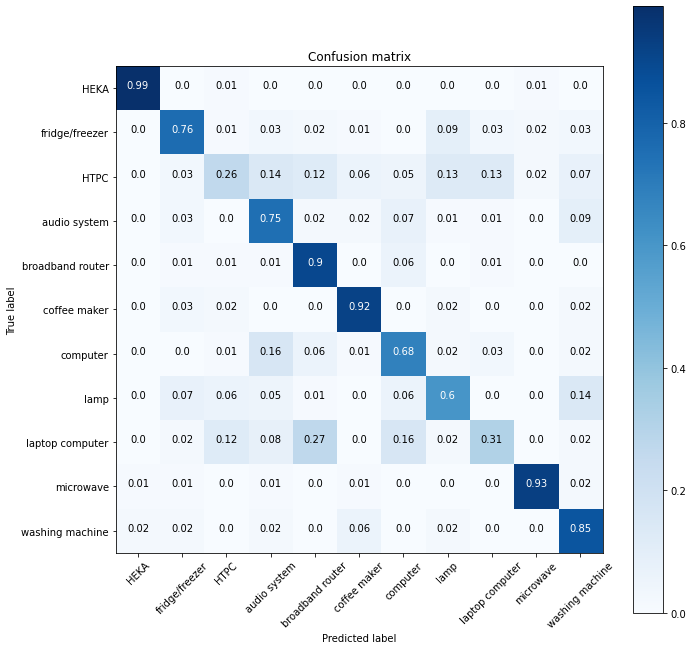

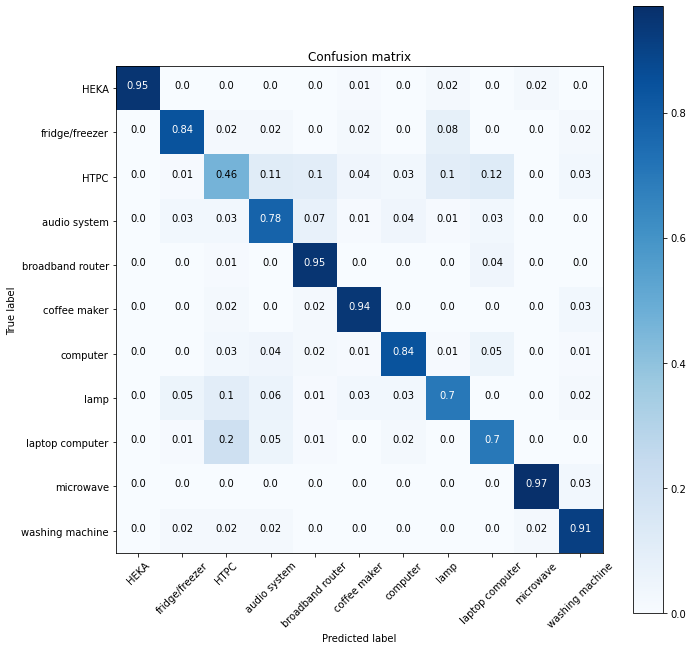

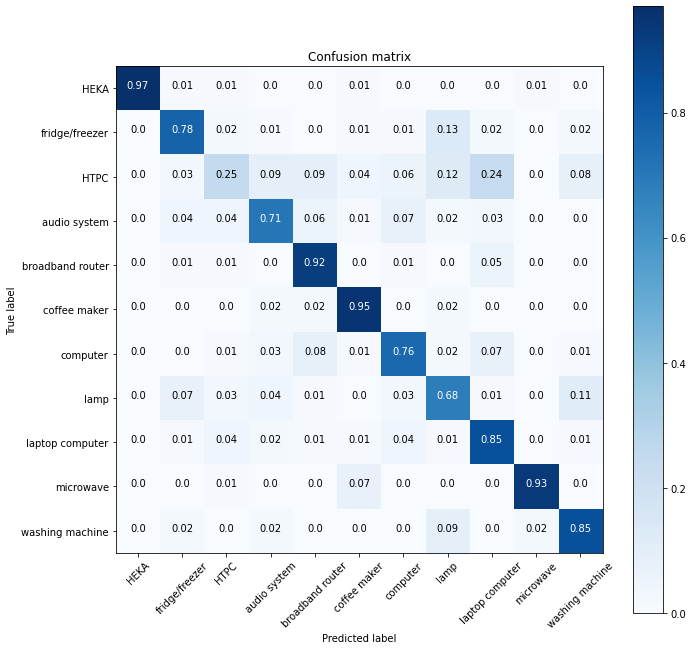

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()